In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_data_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/Build deep learning models with tensorflow/Image Classification/classification-challenge.zip (Unzipped Files)/Covid19-identification/classification-challenge.zip (Unzipped Files)/classification-challenge/classification-challenge-starter/Covid19-dataset/train'
validation_data_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning/Build deep learning models with tensorflow/Image Classification/classification-challenge.zip (Unzipped Files)/Covid19-identification/classification-challenge.zip (Unzipped Files)/classification-challenge/classification-challenge-starter/Covid19-dataset/test'

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

BATCH_SIZE = 16

# Data augmentation and prerocessing 
print("\nLoading training data...")

training_data_generator = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=15,
        width_shift_range=0.05,
        height_shift_range=0.05)

training_iterator = training_data_generator.flow_from_directory(train_data_dir,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)


print("\nLoading validation data...")

#1) Create validation_data_generator, an ImageDataGenerator that just performs pixel normalization:


validation_data_generator = ImageDataGenerator(rescale = 1./255)
#2) Use validation_data_generator.flow_from_directory(...) to load the validation data from the 'data/test' folder:

validation_iterator = validation_data_generator.flow_from_directory(validation_data_dir, class_mode = 'categorical', color_mode = 'grayscale', batch_size = BATCH_SIZE)

print("\nBuilding model...")

#Creating the model, with convolutional and max pooling layers:

model = tf.keras.Sequential()
# Our input feature map is 256x256x1: 256x256 for the image pixels, and 1 for
# the color channel: grayscale
model.add(tf.keras.Input(shape=(256, 256, 1)))

# First convolution extracts 2 filters that are 5x5
# Convolution is followed by max-pooling layer with a 5x5 window
model.add(tf.keras.layers.Conv2D(128, 5, strides=2, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(5, 5), strides=(5,5)))

# # Second convolution extracts 4 filters that are 5x5
# Convolution is followed by max-pooling layer with a 5x5 window
model.add(tf.keras.layers.Conv2D(64, 5, strides=1, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(3, 3), strides=(3,3)))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, 5, strides=1, activation="relu")) 
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=(3,3)))
model.add(tf.keras.layers.Dropout(0.3))

# Flatten feature map to a 1-dim tensor
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.3))

# Create output layer with a single node and softmax activation
model.add(tf.keras.layers.Dense(2,activation="softmax"))

model.summary()


print("\nCompiling model...")

#3) Compile the model with an Adam optimizer, Categorical Cross Entropy Loss, and Accuracy and AUC metrics:
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer=opt,
    loss=loss,
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

print("\nTraining model...")

#4) train and validate model for 5 epochs:

history = model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE,
        epochs=20,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE)


Loading training data...
Found 181 images belonging to 2 classes.

Loading validation data...
Found 46 images belonging to 2 classes.

Building model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 128)     3328      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 64)        204864    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (No

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as numpy
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   
 
cm=confusion_matrix(true_classes,predicted_classes)
print(cm)


              precision    recall  f1-score   support

       Covid       0.64      0.54      0.58        26
      Normal       0.50      0.60      0.55        20

    accuracy                           0.57        46
   macro avg       0.57      0.57      0.56        46
weighted avg       0.58      0.57      0.57        46

[[14 12]
 [ 8 12]]


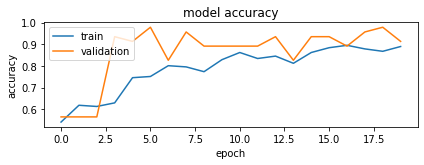

In [21]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')
 
# used to keep plots from overlapping
fig.tight_layout()
plt.show()
# fig.savefig('static/images/my_plots.png')